In [0]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [3]:
device_name = tf.test.gpu_device_name() #GPU Run Check
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/splitlabel/'
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/467case_cut/'
os.listdir(DATA_PATH)

['수관-공 모양.xlsx',
 '뿌리-부재2.xlsx',
 'train_위치-나무-정중앙.xlsx',
 'train_위치-나무-아래.xlsx',
 '위치-나무-정중앙.xlsx',
 '크기-나무-크다.xlsx',
 'test_가지-부재.xlsx',
 '기둥-옹이구멍 안 동물.xlsx',
 'test_뿌리-부재1.xlsx',
 'test_위치-나무-아래.xlsx',
 'test_기둥-상처, 옹이구멍.xlsx',
 'test_절단-나무-오른쪽.xlsx',
 'train_수관-공 모양.xlsx',
 'train_가지-옆으로 벌어짐.xlsx',
 '위치-나무-위.xlsx',
 '절단-나무-위.xlsx',
 'train_뿌리-부재2.xlsx',
 'train_가지-부재.xlsx',
 '가지-부재.xlsx',
 'train_기둥-상처, 옹이구멍.xlsx',
 'test_크기-나무-크다.xlsx',
 'train_크기-나무-크다.xlsx',
 '위치-나무-아래.xlsx',
 'test_기둥-옹이구멍 안 동물.xlsx',
 'train_위치-나무-위.xlsx',
 'test_가지-옆으로 벌어짐.xlsx',
 '가지-아래로 늘어진 가지.xlsx',
 'test_절단-나무-위.xlsx',
 'train_절단-나무-오른쪽.xlsx',
 'test_수관-공 모양.xlsx',
 'train_기둥-옹이구멍 안 동물.xlsx',
 'train_절단-나무-위.xlsx',
 '절단-나무-오른쪽.xlsx',
 'train_뿌리-부재1.xlsx',
 'test_가지-아래로 늘어진 가지.xlsx',
 '가지-옆으로 벌어짐.xlsx',
 '기둥-상처, 옹이구멍.xlsx',
 'test_뿌리-부재2.xlsx',
 'train_가지-아래로 늘어진 가지.xlsx',
 '뿌리-부재1.xlsx',
 'test_위치-나무-정중앙.xlsx',
 'test_위치-나무-위.xlsx']

In [0]:
tree = ['크기-나무-크다',
           '위치-나무-정중앙',
            '위치-나무-아래',
            '위치-나무-위',
            '절단-나무-위',
            '절단-나무-오른쪽',
            '가지-아래로 늘어진 가지',
            '뿌리-부재1',
            '수관-공 모양',
            '기둥-옹이구멍 안 동물',
            '가지-부재',
            '뿌리-부재2',
            '가지-옆으로 벌어짐',
            '기둥-상처, 옹이구멍'
            ]

In [0]:
# TRAIN_CROP_PATH = '/Users/Il-hyeon/Documents/Data/train_crop'
TRAIN_IMG_PATH = os.path.join(IMG_PATH, 'tree')

df_train = []
df_test = []
for excel_name in tree:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH, 'train_' + excel_name + '.xlsx')))
    df_train[tree.index(excel_name)]['data'] = df_train[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH, 'test_' + excel_name + '.xlsx')))
    df_test[tree.index(excel_name)]['data'] = df_test[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [8]:
for i in range(len(tree)):
    print(df_train[i].head())
    print(df_test[i].head())

   Unnamed: 0        data  크기-나무-크다
0         174  0200_T.jpg         1
1         272  0317_T.jpg         1
2         170  0196_T.jpg         1
3           8  0009_T.jpg         1
4         214  0245_T.jpg         1
   Unnamed: 0        data  크기-나무-크다
0         433  0502_T.jpg         1
1          71  0072_T.jpg         0
2           7  0008_T.jpg         1
3         352  0421_T.jpg         1
4         444  0513_T.jpg         1
   Unnamed: 0        data  위치-나무-정중앙
0         220  0252_T.jpg          0
1         363  0432_T.jpg          0
2         394  0463_T.jpg          0
3         142  0159_T.jpg          0
4          41  0042_T.jpg          0
   Unnamed: 0        data  위치-나무-정중앙
0         442  0511_T.jpg          0
1         324  0393_T.jpg          0
2         159  0182_T.jpg          0
3         269  0312_T.jpg          0
4         101  0102_T.jpg          0
   Unnamed: 0        data  위치-나무-아래
0         253  0292_T.jpg         0
1         375  0444_T.jpg         1
2          69  0

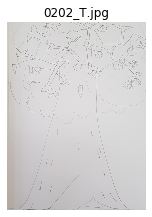

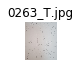

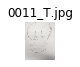

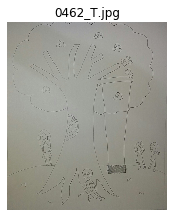

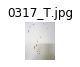

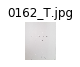

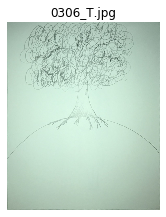

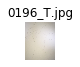

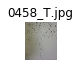

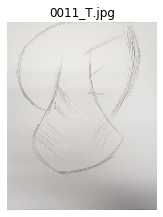

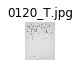

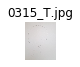

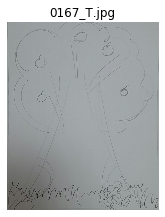

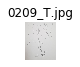

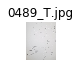

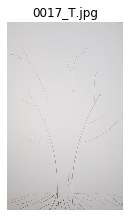

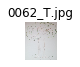

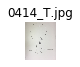

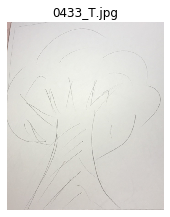

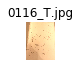

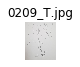

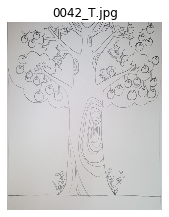

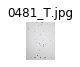

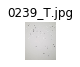

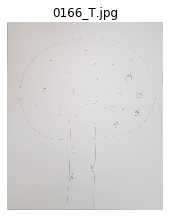

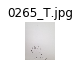

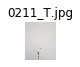

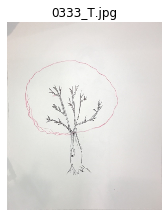

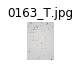

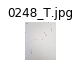

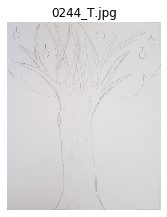

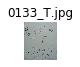

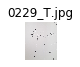

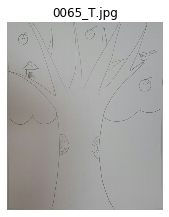

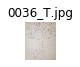

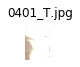

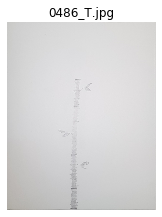

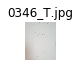

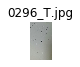

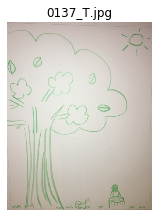

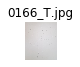

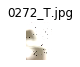

In [9]:
for i in range(len(df_train)):
    tmp_img = df_train[i]['data'][100:103]
    plt.figure(figsize=(12, 20))
    
    for num, f_name in enumerate(tmp_img):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X_train = []
X_val = []

for i, data in enumerate(tree):
    
    df_train[i][data] = df_train[i][data].astype('str')
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]
    
    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, test_size = 0.2, random_state = 42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])
    
    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print('='*20)

크기-나무-크다
(298, 2)
(75, 2)
(373, 2)
위치-나무-정중앙
(298, 2)
(75, 2)
(373, 2)
위치-나무-아래
(298, 2)
(75, 2)
(373, 2)
위치-나무-위
(298, 2)
(75, 2)
(373, 2)
절단-나무-위
(298, 2)
(75, 2)
(373, 2)
절단-나무-오른쪽
(298, 2)
(75, 2)
(373, 2)
가지-아래로 늘어진 가지
(298, 2)
(75, 2)
(373, 2)
뿌리-부재1
(298, 2)
(75, 2)
(373, 2)
수관-공 모양
(298, 2)
(75, 2)
(373, 2)
기둥-옹이구멍 안 동물
(298, 2)
(75, 2)
(373, 2)
가지-부재
(298, 2)
(75, 2)
(373, 2)
뿌리-부재2
(298, 2)
(75, 2)
(373, 2)
가지-옆으로 벌어짐
(298, 2)
(75, 2)
(373, 2)
기둥-상처, 옹이구멍
(298, 2)
(75, 2)
(373, 2)


In [0]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
epochs = 20
batch_size = 32
img_size = (224, 224)
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False, 
    # rotation_range = 2,   # image random roation
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(tree):
        nb_train_samples.append(len(X_train[i]))
        nb_validation_samples.append(len(X_val[i]))
        nb_test_samples.append(len(df_train[i]))
        
        train_generator.append(train_datagen.flow_from_dataframe(
            dataframe=X_train[i],
            directory=TRAIN_IMG_PATH,
            x_col = 'data',
            y_col = tree[i],
            target_size = img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            seed=42
        ))
        
        validation_generator.append(val_datagen.flow_from_dataframe(
            dataframe=X_val[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=tree[i],
            target_size=img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=False
        ))
        
        test_generator.append(test_datagen.flow_from_dataframe(
            dataframe=df_test[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=None,
            target_size = img_size,
            color_mode='rgb',
            class_mode=None,
            batch_size=batch_size,
            shuffle=False
        ))

Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 v

In [0]:
# img = load_img('/content/drive/My Drive/Colab Notebooks/Mind_Elevation/467case_cut/tree/0001_T.jpg')
# x = img_to_array(img)
# x = x.reshape((1,) + x.shape)

# i = 0

# for batch in train_datagen.flow(x, batch_size=1, save_to_dir='/content/drive/My Drive/Colab Notebooks/Mind_Elevation/preview', save_prefix='tri', save_format='png'):
#     i += 1
#     if i > 9: 
#         break

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [15]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax', kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
model = MakeMobileModel()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = []

for i in range(len(tree)):
    model = MakeMobileModel()
    filepath = tree[i] + '_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5'
  
    ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
    
    callbackList = [ckpt]
    
    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = 10,
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 43s - loss: 1.5323 - acc: 0.7333 
Epoch 00001: val_acc improved from -inf to 0.73333, saving model to 크기-나무-크다_mobile_model_0.73_1.5323.h5
10/10 [==============================] - 98s 10s/step - loss: 1.0750 - acc: 0.6913 - val_loss: 1.5323 - val_acc: 0.7333
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 4.5956 - acc: 0.3067
Epoch 00002: val_acc did not improve from 0.73333
10/10 [==============================] - 6s 602ms/step - loss: 0.2282 - acc: 0.9094 - val_loss: 4.5956 - val_acc: 0.3067
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 12.1529 - acc: 0.3067
Epoch 00003: val_acc did not improve from 0.73333
10/10 [==============================] - 8s 803ms/step - loss: 0.0966 - acc: 0.9698 - val_loss: 12.1529 - val_acc: 0.3067
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 15.3085 - acc: 0.3067
Epoch 00004: val_acc did not improve from 0.73333
10/10 [===============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 45s - loss: 0.1757 - acc: 0.9733 
Epoch 00001: val_acc improved from -inf to 0.97333, saving model to 위치-나무-정중앙_mobile_model_0.97_0.1757.h5
10/10 [==============================] - 102s 10s/step - loss: 0.4652 - acc: 0.8154 - val_loss: 0.1757 - val_acc: 0.9733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.4393 - acc: 0.9733
Epoch 00002: val_acc did not improve from 0.97333
10/10 [==============================] - 6s 596ms/step - loss: 0.0371 - acc: 0.9966 - val_loss: 0.4393 - val_acc: 0.9733
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.1932 - acc: 0.9733
Epoch 00003: val_acc did not improve from 0.97333
10/10 [==============================] - 8s 810ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.1932 - val_acc: 0.9733
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.1408 - acc: 0.9733
Epoch 00004: val_acc did not improve from 0.97333
10/10 [================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 48s - loss: 1.6581 - acc: 0.4400 
Epoch 00001: val_acc improved from -inf to 0.44000, saving model to 위치-나무-아래_mobile_model_0.44_1.6581.h5
10/10 [==============================] - 107s 11s/step - loss: 0.6497 - acc: 0.7416 - val_loss: 1.6581 - val_acc: 0.4400
Epoch 2/20
 3/10 [========>.....................] - ETA: 6s - loss: 0.4729 - acc: 0.7200
Epoch 00002: val_acc improved from 0.44000 to 0.72000, saving model to 위치-나무-아래_mobile_model_0.72_0.4729.h5
10/10 [==============================] - 7s 676ms/step - loss: 0.2193 - acc: 0.9430 - val_loss: 0.4729 - val_acc: 0.7200
Epoch 3/20
 3/10 [========>.....................] - ETA: 6s - loss: 1.4643 - acc: 0.5733
Epoch 00003: val_acc did not improve from 0.72000
10/10 [==============================] - 8s 830ms/step - loss: 0.1282 - acc: 0.9698 - val_loss: 1.4643 - val_acc: 0.5733
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.7608 - acc: 0.3867
Epoch 00004: val

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 48s - loss: 4.8870 - acc: 0.7333 
Epoch 00001: val_acc improved from -inf to 0.73333, saving model to 위치-나무-위_mobile_model_0.73_4.8870.h5
10/10 [==============================] - 108s 11s/step - loss: 0.9850 - acc: 0.6779 - val_loss: 4.8870 - val_acc: 0.7333
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.7685 - acc: 0.7467
Epoch 00002: val_acc improved from 0.73333 to 0.74667, saving model to 위치-나무-위_mobile_model_0.75_0.7685.h5
10/10 [==============================] - 7s 662ms/step - loss: 0.4818 - acc: 0.8523 - val_loss: 0.7685 - val_acc: 0.7467
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.2359 - acc: 0.7467
Epoch 00003: val_acc did not improve from 0.74667
10/10 [==============================] - 8s 816ms/step - loss: 0.4469 - acc: 0.9094 - val_loss: 1.2359 - val_acc: 0.7467
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.5103 - acc: 0.3867
Epoch 00004: val_a

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 48s - loss: 2.2413 - acc: 0.5200 
Epoch 00001: val_acc improved from -inf to 0.52000, saving model to 절단-나무-위_mobile_model_0.52_2.2413.h5
10/10 [==============================] - 109s 11s/step - loss: 1.1134 - acc: 0.5940 - val_loss: 2.2413 - val_acc: 0.5200
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.1406 - acc: 0.6933
Epoch 00002: val_acc improved from 0.52000 to 0.69333, saving model to 절단-나무-위_mobile_model_0.69_1.1406.h5
10/10 [==============================] - 7s 675ms/step - loss: 0.3211 - acc: 0.8826 - val_loss: 1.1406 - val_acc: 0.6933
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 3.2031 - acc: 0.5200
Epoch 00003: val_acc did not improve from 0.69333
10/10 [==============================] - 8s 833ms/step - loss: 0.1059 - acc: 0.9597 - val_loss: 3.2031 - val_acc: 0.5200
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.3997 - acc: 0.6400
Epoch 00004: val_a

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 49s - loss: 5.5835 - acc: 0.6933 
Epoch 00001: val_acc improved from -inf to 0.69333, saving model to 절단-나무-오른쪽_mobile_model_0.69_5.5835.h5
10/10 [==============================] - 111s 11s/step - loss: 0.8755 - acc: 0.7148 - val_loss: 5.5835 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 3.5279 - acc: 0.6933
Epoch 00002: val_acc did not improve from 0.69333
10/10 [==============================] - 6s 622ms/step - loss: 0.3328 - acc: 0.8725 - val_loss: 3.5279 - val_acc: 0.6933
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.2987 - acc: 0.5467
Epoch 00003: val_acc did not improve from 0.69333
10/10 [==============================] - 8s 811ms/step - loss: 0.1066 - acc: 0.9597 - val_loss: 2.2987 - val_acc: 0.5467
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.9214 - acc: 0.7733
Epoch 00004: val_acc improved from 0.69333 to 0.77333, saving model to 절단

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 48s - loss: 0.1085 - acc: 0.9867 
Epoch 00001: val_acc improved from -inf to 0.98667, saving model to 가지-아래로 늘어진 가지_mobile_model_0.99_0.1085.h5
10/10 [==============================] - 111s 11s/step - loss: 0.1297 - acc: 0.9597 - val_loss: 0.1085 - val_acc: 0.9867
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2717 - acc: 0.9867
Epoch 00002: val_acc did not improve from 0.98667
10/10 [==============================] - 6s 613ms/step - loss: 0.0245 - acc: 0.9933 - val_loss: 0.2717 - val_acc: 0.9867
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.1150 - acc: 0.9467
Epoch 00003: val_acc did not improve from 0.98667
10/10 [==============================] - 8s 806ms/step - loss: 0.0515 - acc: 0.9933 - val_loss: 0.1150 - val_acc: 0.9467
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.0709 - acc: 0.9867
Epoch 00004: val_acc did not improve from 0.98667
10/10 [============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 9/10 [==========================>...] - ETA: 5s - loss: 0.1794 - acc: 0.9361 Epoch 1/20


ValueError: ignored

크기-나무-크다


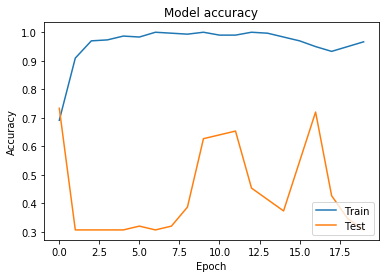

위치-나무-정중앙


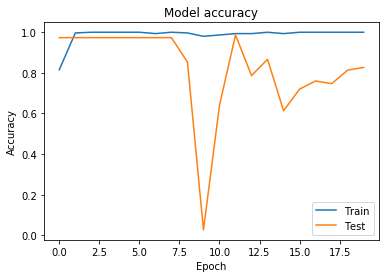

위치-나무-아래


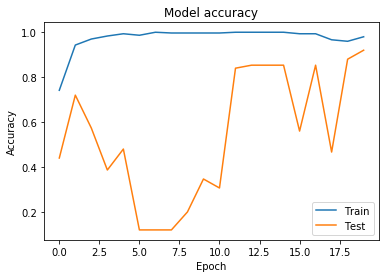

위치-나무-위


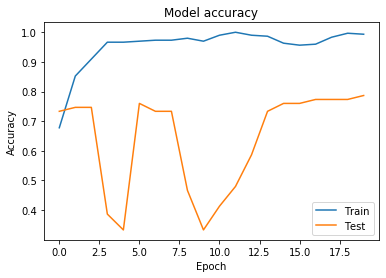

절단-나무-위


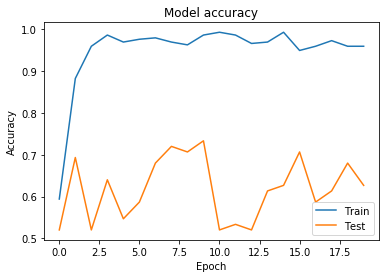

절단-나무-오른쪽


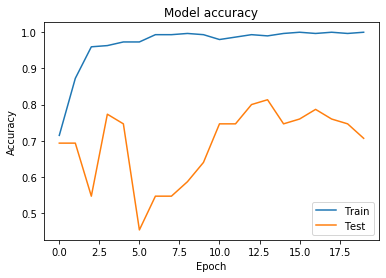

가지-아래로 늘어진 가지


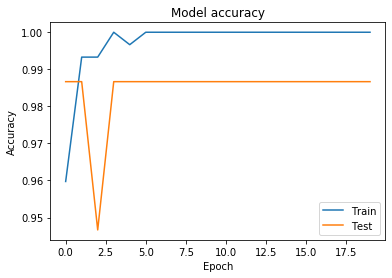

뿌리-부재1


IndexError: ignored

In [31]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['acc'])
        plt.plot(history[i].history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='lower right')
        plt.show()

크기-나무-크다


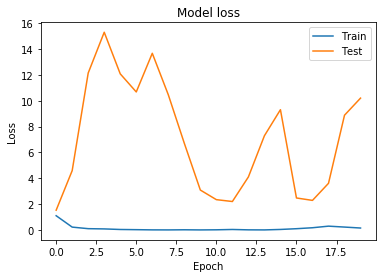

위치-나무-정중앙


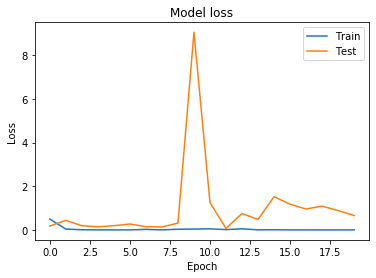

위치-나무-아래


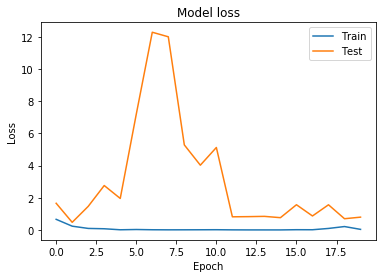

위치-나무-위


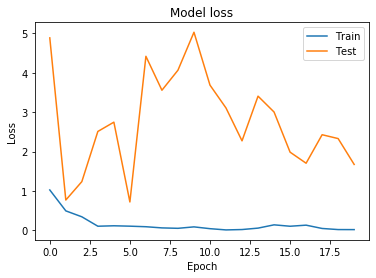

절단-나무-위


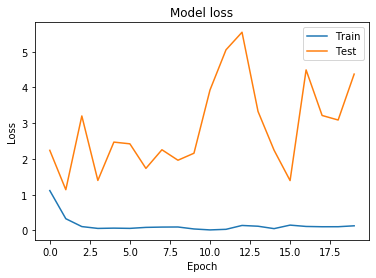

절단-나무-오른쪽


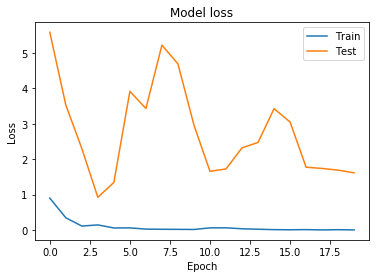

가지-아래로 늘어진 가지


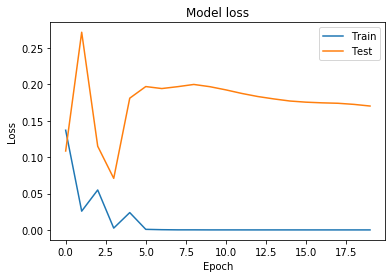

뿌리-부재1


IndexError: ignored

In [32]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['loss'])
        plt.plot(history[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

In [35]:
model_list = []
for num, h in enumerate(tree):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

['크기-나무-크다_mobile_model_0.31_7.9739.h5', '크기-나무-크다_mobile_model_0.33_6.6987.h5', '크기-나무-크다_mobile_model_0.36_7.3185.h5', '크기-나무-크다_mobile_model_0.44_1.9996.h5', '크기-나무-크다_mobile_model_0.65_2.3491.h5', '크기-나무-크다_mobile_model_0.68_0.8970.h5', '크기-나무-크다_mobile_model_0.69_1.8315.h5', '크기-나무-크다_mobile_model_0.69_4.3511.h5', '크기-나무-크다_mobile_model_0.69_5.3660.h5', '크기-나무-크다_mobile_model_0.71_1.5710.h5', '크기-나무-크다_mobile_model_0.71_1.6505.h5', '크기-나무-크다_mobile_model_0.71_2.9381.h5', '크기-나무-크다_mobile_model_0.73_1.5323.h5', '크기-나무-크다_mobile_model_0.75_1.2955.h5', '크기-나무-크다_mobile_model_0.76_1.1654.h5', '크기-나무-크다_mobile_model_0.76_2.1236.h5', '크기-나무-크다_mobile_model_0.76_2.1504.h5', '크기-나무-크다_mobile_model_0.77_1.1134.h5', '크기-나무-크다_mobile_model_0.79_1.6774.h5', '크기-나무-크다_mobile_model_0.80_1.0318.h5', '크기-나무-크다_mobile_model_0.80_1.0731.h5', '크기-나무-크다_mobile_model_0.81_1.4473.h5']
['위치-나무-정중앙_mobile_model_0.04_4.5029.h5', '위치-나무-정중앙_mobile_model_0.15_2.7460.h5', '위치-나무-정중앙_mobile_model_0.39_1.6790.

In [36]:
prediction = []
for i, h in enumerate(tree):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose = 1
        ))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



12/12 [==============================] - 24s 2s/step

12/12 [==============================] - 24s 2s/step

12/12 [==============================] - 24s 2s/step

12/12 [==============================] - 25s 2s/step

12/12 [==============================] - 24s 2s/step

12/12 [==============================] - 25s 2s/step

12/12 [==============================] - 25s 2s/step


IndexError: ignored

In [39]:
for i, h in enumerate(tree):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    submission[h + "_class"] = predictions
    print(submission.head(10))
    submission.to_excel("h_" + h + "_submission.xlsx", index=False)
    print('='*20)

376
df_test (94, 1)
prediction (376, 2)


FileNotFoundError: ignored

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [0]:
def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [0]:
for h in tree:
    submission = pd.read_excel('h_'+h+'_submission.xlsx')
    print(h, ':', micro_f1(submission[h], submission[h + '_class']))

In [0]:
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']

    for i in range(len(excel)):
        if(actual[i] == predicted[i]):
            if actual[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if actual[i] == 1:
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP

    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)

    return TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu

In [0]:
bestfeatures = ['가지-아래로 늘어진 가지',
                '위치-나무-아래',
                '위치-나무-정중앙'
                ]

In [27]:
for h in bestfeatures:
    excel = pd.read_excel('./bestfeatures/h_'+h+'_submission.xlsx')
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('Flase Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('negative_predictive_values : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print('f1 score : ', micro_f1(excel[h], excel[h+ '_class']))
    print('='*40)

FileNotFoundError: ignored

In [0]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

# def f1_score(precision, recall):
#     f1 = 2 * precision * recall / (precision + recall)

    print('오차행렬\n')
    print(confusion)
    print('정확도 : {0: 4f}, 정밀도 : {1: 4f}, 재현율 : {2: 4f}, F1 Score : {2: 4f}'.format(accuracy, precision, recall, f1))

In [0]:
print(get_clf_eval(y_col, pred))

NameError: ignored

In [0]:
def plot_confusion_matrix(y_ture, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Noramlized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_ture, y_pred)
    classes = classes[unique_labels(y_ture, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arrage(cm.shape[1]),
           yticks=np.arrage(cm.shape[0]),
           xticklabels=classes, yticklabel=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: ignored